# Student Performance from Game Play Using TensorFlow Decision Forests

---

This notebook will take you through the steps needed to train a baseline Gradient Boosted Trees Model using TensorFlow Decision Forests on the `Student Performance from Game Play` dataset made available for this competition, to predict if players will answer questions correctly.
We will load the data from a CSV file. Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd
  
dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.GradientBoostedTreesModel()
model.fit(tf_dataset)
  
print(model.summary())
```

We will also learn how to optimize reading of big datasets, do some feature engineering, data visualization and calculate better results using the F1-score


Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

One of the key aspects of TensorFlow Decision Forests that makes it even more suitable for this competition, particularly given the runtime limitations, is that it has been extensively tested for training and inference on CPUs, making it possible to train it on lower-end machines.

# Import the Required Libraries

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
#import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
print("TensorFlow Decision Forests v" + tfdf.__version__)
print("TensorFlow Addons v" + tfa.__version__)
print("TensorFlow v" + tf.__version__)
# get working directory and remove last folder
wd = os.path.dirname(os.getcwd())
os.chdir(wd)
print("Working Directory: ", os.getcwd())

NameError: name 'tfdf' is not defined

# Load the Dataset

Since the dataset is huge, some people may face memory errors while reading the dataset from the csv. To avoid this, we will try to optimize the memory used by Pandas to load and store the dataset.


When Pandas loads a dataset, by default, it automatically detects the data types of the different columns.
Irresepective of the maximum value that is stored in these columns, Pandas assigns `int64` for numerical columns, `float64` for float columns, `object` dtype for string columns etc.


We may be able to reduce the size of these columns in memory by downcasting numerical columns to smaller types (like `int8`, `int32`, `float32` etc.), if their maximum values don't need the larger types for storage, (like `int64`, `float64` etc.).


Similarly, Pandas automatically detects string columns as `object` datatype. To reduce memory usage of string columns which store categorical data, we specify their datatype as `category`.


Many of the columns in this dataset can be downcast to smaller types.

We will provide a dict of `dtypes` for columns to pandas while reading the dataset.

In [3]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('data/raw/train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


The data is composed of 20 columns and 26296946 entries. We can see all 20 dimensions of our dataset by printing out the first 5 entries using the following code:

In [4]:
# Display the first 5 examples
dataset_df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


Please note that `session_id` uniquely identifies a user session.

# Load the labels

The labels for the training dataset are stored in the `train_labels.csv`. It consists of the information on whether the user in a particular session answered each question correctly. Load the labels data by running the following code. `

In [5]:
labels = pd.read_csv('data/raw/train_labels.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/train_labels.csv'

Each value in the column, `session_id` is a combination of both the session and the question number. 
We will split these into individual columns for ease of use.

In [6]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

 Let us take a look at the first 5 entries of `labels` using the following code:

In [7]:
# Display the first 5 examples
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


Our goal is to train models for each question to predict the label `correct` for any input user session. 

# Bar chart for label column: correct

First we will plot a bar chart for the values of the label `correct`.

<Axes: xlabel='correct'>

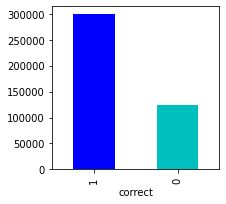

In [8]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

Now, let us plot the values of the label column `correct` for each question.

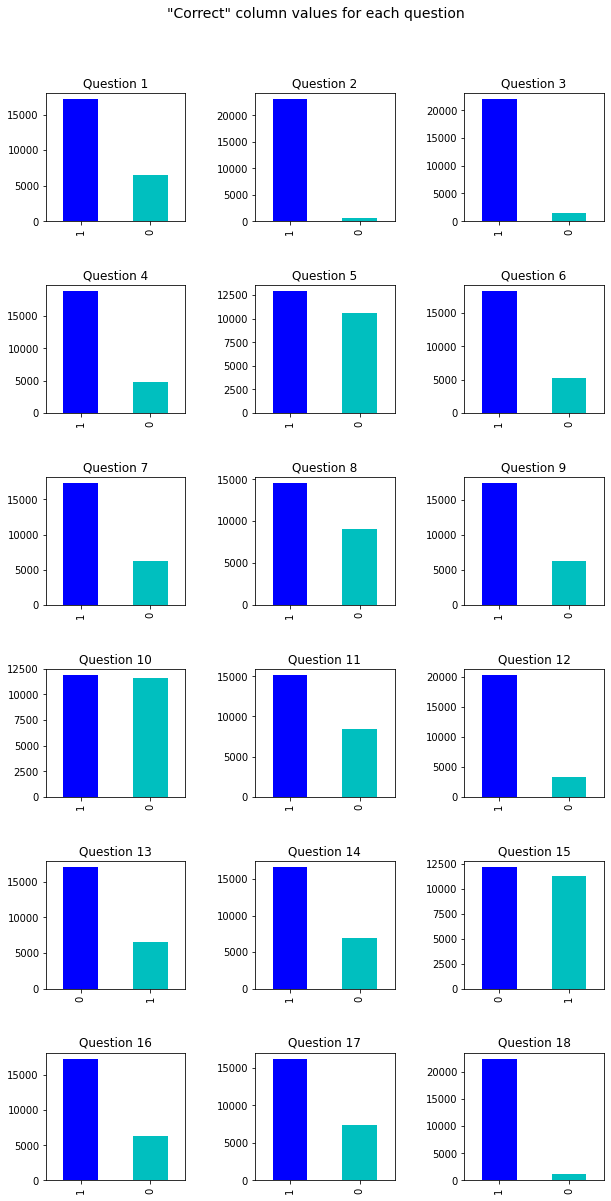

In [9]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'c'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")


# Prepare the dataset

As summarized in the competition overview, the dataset presents the questions and data to us in order of `levels - level segments`(represented by column `level_group`) 0-4, 5-12, and 13-22. We have to predict the correctness of each segment's questions as they are presented. To do this we will create basic aggregate features from the relevant columns. You can create more features to boost your scores. 

First, we will create two separate lists with names of the Categorical columns and Numerical columns. We will avoid columns `fullscreen`, `hq` and `music` since they don't add any useful value for this problem statement.

In [10]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

For each categorical column, we will first group the dataset by `session_id`  and `level_group`. We will then count the number of **distinct elements** in the column for each group and store it temporarily.

For all numerical columns, we will group the dataset by `session id` and `level_group`. Instead of counting the number of distinct elements, we will calculate the `mean` and `standard deviation` of the numerical column for each group and store it temporarily.

After this, we will concatenate the temporary data frames we generated in the earlier step for each column to create our new feature engineered dataset.

In [11]:
# Reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [12]:
dataset_df = feature_engineer(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (70686, 22)


Our feature engineered dataset is composed of 22 columns and 70686 entries. 

# Basic exploration of the prepared dataset

Let us print out the first 5 entries using the following code:

In [13]:
# Display the first 5 examples
dataset_df.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044861,2389.500000,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,379.301025,899.925903,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784912,969.333313,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,370.723083,1378.750000,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,387.930084,720.384949,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [14]:
dataset_df.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,7.068600e+04,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,2.811806e+06,9.311221,1.439995,-33.454849,-92.222832,...,379.749146,4.119625e+03,9.322398e+05,1.916549,0.038805,468.689088,183.186301,240.795420,124.016602,1.322598e+04
std,0.832923,0.799293,13.020929,2.928351,8.989095,2.289877e+07,6.523788,2.350494,80.784378,69.349052,...,36.971046,1.394260e+05,1.206491e+07,0.492239,0.785170,106.991644,48.884988,28.709135,15.844603,4.868272e+05
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.591262e+02,0.923372,-1.000000,-461.440765,-409.231293,...,177.051849,-1.000000e+00,2.337003e+02,0.684670,-1.000000,261.425412,90.098533,109.415466,68.257406,-1.000000e+00
25%,10.000000,3.000000,25.000000,7.000000,15.000000,1.642777e+05,2.051613,-1.000000,-90.615677,-151.717484,...,358.117455,9.709706e+02,8.240024e+04,1.295298,-1.000000,381.066225,143.588600,222.569734,113.994303,1.368802e+03
50%,11.000000,4.000000,43.000000,11.000000,23.000000,5.882137e+05,8.140526,1.000000,-20.255625,-71.538723,...,377.843857,1.427761e+03,1.440869e+05,2.099711,0.000000,431.901352,162.941973,238.383832,122.388964,2.041432e+03
75%,11.000000,4.000000,51.000000,12.000000,32.000000,1.351434e+06,17.592593,4.000000,23.220109,-38.693486,...,397.018394,2.158794e+03,2.240529e+05,2.316163,0.735893,585.347609,233.385259,255.083349,132.067430,3.105588e+03
max,11.000000,6.000000,81.000000,17.000000,48.000000,1.191886e+09,20.222101,6.000000,328.096100,160.347977,...,986.192993,2.772298e+07,9.946229e+08,3.580235,2.715695,817.257133,349.049304,612.958607,331.833790,7.837739e+07


# Numerical data distribution¶

Let us plot some numerical columns and their value against each level_group:

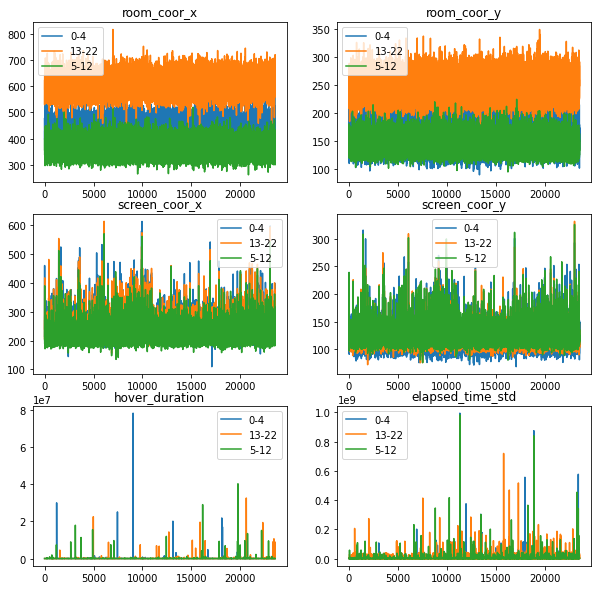

In [15]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['screen_coor_x_std'])+1), data['screen_coor_x_std'], label=name)
    axis[1, 1].plot(range(1, len(data['screen_coor_y_std'])+1), data['screen_coor_y_std'], label=name)
    axis[2, 0].plot(range(1, len(data['hover_duration'])+1), data['hover_duration_std'], label=name)
    axis[2, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)
    

axis[0, 0].set_title('room_coor_x')
axis[0, 1].set_title('room_coor_y')
axis[1, 0].set_title('screen_coor_x')
axis[1, 1].set_title('screen_coor_y')
axis[2, 0].set_title('hover_duration')
axis[2, 1].set_title('elapsed_time_std')

for i in range(3):
    axis[i, 0].legend()
    axis[i, 1].legend()

plt.show()

Now let us split the dataset into training and testing datasets:

In [16]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset_df.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

56547 examples in training, 14139 examples in testing.


# Select a Model
There are several tree-based models for you to choose from.

- RandomForestModel
- GradientBoostedTreesModel
- CartModel
- DistributedGradientBoostedTreesModel

We can list all the available models in TensorFlow Decision Forests using the following code:

In [17]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

To get started, we'll work with a Gradient Boosted Trees Model. This is one of the well-known Decision Forest training algorithms.

A Gradient Boosted Decision Tree is a set of shallow decision trees trained sequentially. Each tree is trained to predict and then "correct" for the errors of the previously trained trees.

# How can I configure a tree-based model?

TensorFlow Decision Forests provides good defaults for you (e.g., the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:
```
rf = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
```

You can read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel).

# Training


We will train a model for each question to predict if the question will be answered correctly by a user. 
There are a total of 18 questions in the dataset. Hence, we will be training 18 models, one for each question.

We need to provide a few data structures to our training loop to store the trained models, predictions on the validation set and evaluation scores for the trained models.

We will create these using the following code:


In [18]:
# Fetch the unique list of user sessions in the validation dataset. We assigned 
# `session_id` as the index of our feature engineered dataset. Hence fetching 
# the unique values in the index column will give us a list of users in the 
# validation set.
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is: 
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s. 
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

Before training the data we have to understand how `level_groups` and `questions` are associated to each other.

In this game the first quiz checkpoint(i.e., questions 1 to 3) comes after finishing levels 0 to 4. So for training questions 1 to 3 we will use data from the `level_group` 0-4. Similarly, we will use data from the `level_group` 5-12 to train questions from 4 to 13 and data from the `level_group` 13-22 to train questions from 14 to 18.

We will train a model for each question and store the trained model in the `models` dict.

In [19]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Gradient Boosted Trees Model with default settings. 
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.GradientBoostedTreesModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])

    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]         

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()     

### q_no 1 grp 0-4


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp391m7yc5/model/ with prefix 069eb6c017234c66
[INFO quick_scorer_

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 10ms/step
### q_no 2 grp 0-4


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp4vjir2u2/model/ with prefix 04fbcda7267b4084
[INFO kernel.cc:102

5/5 [==============================] - 0s 11ms/step
### q_no 3 grp 0-4


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpf4ukkd_8/model/ with prefix 531794c7e7574c40
[INFO kernel.cc:102

5/5 [==============================] - 0s 14ms/step
### q_no 4 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp8112vis1/model/ with prefix a12dc8129c5b4953
[INFO kernel.cc:102

5/5 [==============================] - 0s 12ms/step
### q_no 5 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpvxjmpfsy/model/ with prefix 87336052b90c4236
[INFO abstract_model.cc:1249] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1022] Use fast generic engine


5/5 [==============================] - 0s 11ms/step
### q_no 6 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp0eutpk9b/model/ with prefix e3cce33229c0480e
[INFO kernel.cc:1022] Use fast generic engine


5/5 [==============================] - 0s 11ms/step
### q_no 7 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpqjmmdga6/model/ with prefix 3bf390a418514537
[INFO kernel.cc:102

5/5 [==============================] - 0s 11ms/step
### q_no 8 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp1z2tuotn/model/ with prefix 4cc9af71162d433c
[INFO kernel.cc:102

5/5 [==============================] - 0s 15ms/step
### q_no 9 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp9jp_0h5q/model/ with prefix ef1eefc7cb8c4872
[INFO kernel.cc:102

5/5 [==============================] - 0s 11ms/step
### q_no 10 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpe506qq03/model/ with prefix 344b1cd703ff4c66
[INFO abstract_mode

5/5 [==============================] - 0s 10ms/step
### q_no 11 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp0_ivdqfg/model/ with prefix 2b3fa8daf2ac40e2
[INFO kernel.cc:102

5/5 [==============================] - 0s 12ms/step
### q_no 12 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpptpbi3z7/model/ with prefix 27f2f4a6159543c1
[INFO kernel.cc:102

5/5 [==============================] - 0s 14ms/step
### q_no 13 grp 5-12


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpoqtzah1g/model/ with prefix 929f38a13f9b4a33
[INFO kernel.cc:102

5/5 [==============================] - 0s 13ms/step
### q_no 14 grp 13-22


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp4p68u43o/model/ with prefix cdea189f4600479e
[INFO quick_scorer_

5/5 [==============================] - 0s 17ms/step
### q_no 15 grp 13-22


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpmtoygwan/model/ with prefix c472c51113dc4107
[INFO abstract_mode

5/5 [==============================] - 0s 12ms/step
### q_no 16 grp 13-22


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpgz_ziwsg/model/ with prefix 6e3072d445844fad
[INFO kernel.cc:102

5/5 [==============================] - 0s 12ms/step
### q_no 17 grp 13-22


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmpt9iyq5o3/model/ with prefix f52eece78d91442b
[INFO kernel.cc:102

5/5 [==============================] - 0s 15ms/step
### q_no 18 grp 13-22


/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/ipykernel_40653/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO kernel.cc:1176] Loading model from path /var/folders/c7/2n0y_9lj69nf7sn_yr7sg46h0000gn/T/tmp4m1mvvyy/model/ with prefix 5f8b7d2b54cc4f15
[INFO kernel.cc:102

5/5 [==============================] - 0s 12ms/step


#### If error at dataframe.drop() occurs, do the following:
1. open this file in text editor:
      ../anaconda3/envs/tf_df/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core_inference.py
2. find the line:
      features_dataframe = dataframe.drop(label, 1)
3. replace it with:
      features_dataframe = dataframe.drop(label, axis=1)
4. save the file
5. restart the kernel

# Inspect the Accuracy of the models.

We trained a model for each question. Now let us check the accuracy of each model and overall accuracy for all the models combined. 

Note: Since the label distribution is imbalanced, we can't make an assumption on the model performance from accuracy score alone. 

In [21]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7286
question 2: accuracy 0.9754
question 3: accuracy 0.9351
question 4: accuracy 0.7957
question 5: accuracy 0.6319
question 6: accuracy 0.7885
question 7: accuracy 0.7456
question 8: accuracy 0.6355
question 9: accuracy 0.7647
question 10: accuracy 0.6109
question 11: accuracy 0.6522
question 12: accuracy 0.8695
question 13: accuracy 0.7218
question 14: accuracy 0.7337
question 15: accuracy 0.6166
question 16: accuracy 0.7488
question 17: accuracy 0.7027
question 18: accuracy 0.9501

Average accuracy 0.7559586928950416


# Visualize the model

One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. 

Let us pick one model from `models` dict and select a tree to display below.

In [22]:
tfdf.model_plotter.plot_model_in_colab(models['0-4_1'], tree_idx=0, max_depth=3)

# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests. Let us pick one model from models dict and inspect it.

Let us list the available Variable Importances for Decision Trees:

In [23]:
inspector = models['0-4_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 NUM_AS_ROOT
	 MEAN_MIN_DEPTH
	 SUM_SCORE


As an example, let us display the important features for the Variable Importance NUM_AS_ROOT.

The larger the importance score for NUM_AS_ROOT, the more impact it has on the outcome of the model for Question 1(i.e., model\["0-4_1"\]).

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the gradient boosted trees  than any other feature.

In [24]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("room_fqid_nunique" (1; #15), 9.0),
 ("name_nunique" (1; #8), 8.0),
 ("level" (1; #6), 5.0),
 ("text_fqid_nunique" (1; #20), 5.0),
 ("hover_duration_std" (1; #5), 4.0),
 ("screen_coor_x_std" (1; #17), 4.0),
 ("elapsed_time" (1; #0), 2.0),
 ("page_std" (1; #10), 2.0),
 ("room_coor_x" (1; #11), 2.0),
 ("event_name_nunique" (1; #2), 1.0),
 ("page" (1; #9), 1.0),
 ("room_coor_y_std" (1; #14), 1.0)]

# Threshold-Moving for Imbalanced Classification

Since the values of the column `correct` is fairly imbalanced, using the default threshold of `0.5` to map the predictions into classes 0 or 1 can result in poor performance. 
In such cases, to improve performance we will calculate the `F1 score` for a certain range of thresholds and try to find the best threshold aka, threshold with highest `F1 score`. Then we will use this threshold to map the predicted probabilities to class labels 0 or 1.

Please note that we are using `F1 score` since it is a better metric than `accuracy` to evaluate problems with class imbalance.

In [25]:
# Create a dataframe of required size:
# (no: of users in validation set x no: of questions) initialized to zero values
# to store true values of the label `correct`. 
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((prediction_df.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.6300000000000002 	F1 score  0.6738663


# Submission

Here you'll use the `best_threshold` calculate in the previous cell

In [26]:
# Reference
# https://www.kaggle.com/code/philculliton/basic-submission-demo
# https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook


from data.raw import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}
lvl_to_group = {}

for (test, sample_submission) in iter_test:
    test_df = feature_engineer(test)
    grp = test_df.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        gbtm = models[f'{grp}_{t}']
        test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df.loc[:, test_df.columns != 'level_group'])
        predictions = gbtm.predict(test_ds)
        mask = sample_submission.session_id.str.contains(f'q{t}')
        n_predictions = (predictions > best_threshold).astype(int)
        sample_submission.loc[mask,'correct'] = n_predictions.flatten()
    
    env.predict(sample_submission)

ModuleNotFoundError: No module named 'data.raw.jo_wilder.competition'

In [ ]:
! head submission.csv